Классы дорожных объектов для распознавания в данной работе: легковой автомобиль, дорожный знак, светофор, пешеход, грузовик, автобус, двухколесный транспорт (велосипед или мотоцикл), человек на двухколёсном транспорте (велосипеде или мотоцикле).

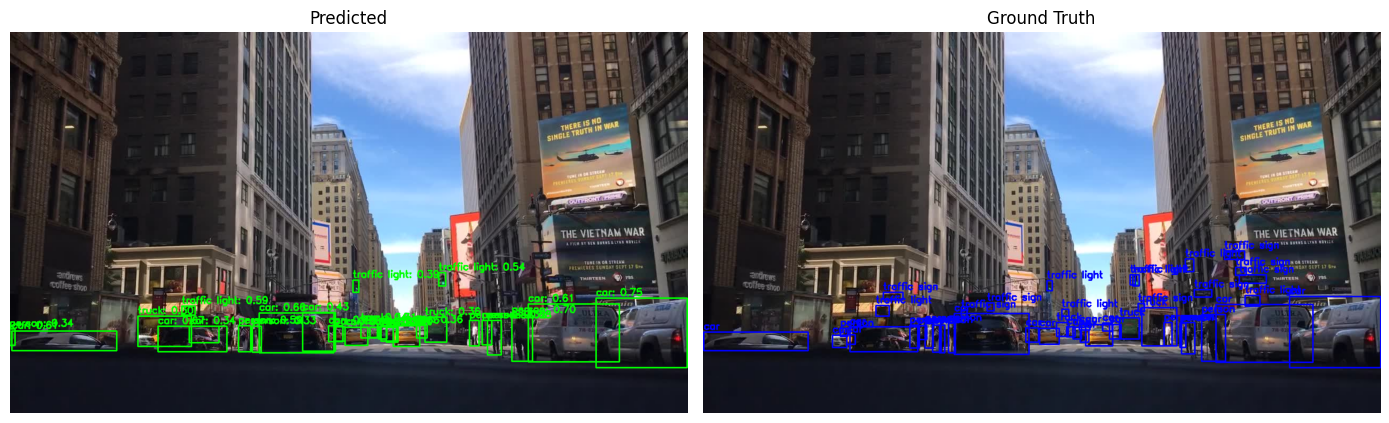


Evaluation for image: b2a8e8b4-50058f09.jpg
Total GT objects     : 45
Predicted objects    : 30
Matched objects (IoU ≥ 0.5) : 21
Precision            : 0.70
Recall               : 0.47
Correct class ratio  : 0.95


In [5]:
import cv2
import json
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from transformers import RTDetrForObjectDetection, RTDetrImageProcessor

# === Параметры ===
image_path = r"C:\Users\odara\Downloads\data\val\images\b2a8e8b4-50058f09.jpg"
checkpoint_path = r"C:\Users\odara\Downloads\data\rtdetr_fine_tuning\checkpoint-210000"
bdd_labels_path = r"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_val.json"
iou_threshold = 0.5

# === Классы (id ↔ name) из ground truth ===
categories = [
    {"id": 0, "name": "car"},
    {"id": 1, "name": "traffic sign"},
    {"id": 2, "name": "traffic light"},
    {"id": 3, "name": "person"},
    {"id": 4, "name": "truck"},
    {"id": 5, "name": "bus"},
    {"id": 6, "name": "two_wheeler"},
    {"id": 7, "name": "rider"},
]
id_to_name = {cat["id"]: cat["name"] for cat in categories}

# === Загрузка модели и процессора ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RTDetrForObjectDetection.from_pretrained(checkpoint_path).to(device)
# processor = RTDetrImageProcessor.from_pretrained(checkpoint_path)
processor = RTDetrImageProcessor.from_pretrained(
    "PekingU/rtdetr_r101vd_coco_o365",
    size={"height": 512, "width": 512}
)

# === Загрузка изображения ===
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# === Инференс ===
inputs = processor(images=image_rgb, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

target_sizes = torch.tensor([image_rgb.shape[:2]])  # (height, width)
results = processor.post_process_object_detection(outputs, threshold=0.3, target_sizes=target_sizes)[0]

pred_boxes = results["boxes"].cpu().numpy()
pred_scores = results["scores"].cpu().numpy()
pred_classes = results["labels"].cpu().numpy()

# === Загрузка GT аннотаций ===
with open(bdd_labels_path, 'r') as f:
    bdd_data = json.load(f)

image_name = Path(image_path).name
gt_boxes = []
gt_classes = []

for item in bdd_data:
    if item['name'] == image_name:
        for label in item.get('labels', []):
            box2d = label.get('box2d')
            if box2d:
                x1, y1 = box2d['x1'], box2d['y1']
                x2, y2 = box2d['x2'], box2d['y2']
                gt_boxes.append([x1, y1, x2, y2])
                gt_classes.append(label['category'])
        break

# === Визуализация ===
def draw_boxes(image, boxes, classes, scores=None, title="", is_pred=False):
    image = image.copy()
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cls = str(classes[i])
        color = (0, 255, 0) if is_pred else (255, 0, 0)
        
        # Формируем текст с confidence, если есть scores
        if scores is not None:
            conf = scores[i]
            text = f"{cls}: {conf:.2f}"
        else:
            text = cls

        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
draw_boxes(
    image, 
    pred_boxes, 
    [id_to_name.get(int(i), "unknown") for i in pred_classes], 
    scores=pred_scores, 
    title="Predicted", 
    is_pred=True
)

plt.subplot(1, 2, 2)
draw_boxes(image, gt_boxes, gt_classes, title="Ground Truth", is_pred=False)
plt.tight_layout()
plt.show()

# === IoU-функция ===
def compute_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    inter_area = max(0, xB - xA) * max(0, yB - yA)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area else 0

# === Сравнение предсказаний и GT ===
matched = 0
correct_class = 0
used_gt = set()

for i, pbox in enumerate(pred_boxes):
    pred_label_name = id_to_name.get(int(pred_classes[i]), "unknown")
    for j, gtbox in enumerate(gt_boxes):
        if j in used_gt:
            continue
        iou = compute_iou(pbox, gtbox)
        if iou >= iou_threshold:
            matched += 1
            used_gt.add(j)
            if pred_label_name == gt_classes[j]:
                correct_class += 1
            break

# === Метрики ===
total_gt = len(gt_boxes)
precision = matched / len(pred_boxes) if pred_boxes.any() else 0
recall = matched / total_gt if total_gt else 0
cls_accuracy = correct_class / matched if matched else 0

print(f"\nEvaluation for image: {image_name}")
print(f"Total GT objects     : {total_gt}")
print(f"Predicted objects    : {len(pred_boxes)}")
print(f"Matched objects (IoU ≥ {iou_threshold}) : {matched}")
print(f"Precision            : {precision:.2f}")
print(f"Recall               : {recall:.2f}")
print(f"Correct class ratio  : {cls_accuracy:.2f}")

In [26]:
import time
import torch

# Старт замера
start_time = time.perf_counter()

# Препроцессинг (подготовка тензоров)
inputs = processor(images=image_rgb, return_tensors="pt").to(device)

# Инференс с синхронизацией CUDA
torch.cuda.synchronize()
model_start = time.perf_counter()

with torch.no_grad():
    outputs = model(**inputs)

torch.cuda.synchronize()
model_end = time.perf_counter()

# Постпроцессинг (разбор выходов)
target_sizes = torch.tensor([image_rgb.shape[:2]])  # (height, width)
results = processor.post_process_object_detection(outputs, threshold=0.3, target_sizes=target_sizes)[0]

end_time = time.perf_counter()

# Время препроцессинга + постпроцессинга (без модели)
prep_post_ms = (end_time - start_time) * 1000 - (model_end - model_start) * 1000
model_ms = (model_end - model_start) * 1000
total_ms = (end_time - start_time) * 1000

print(f"⏱ Время инференса модели (GPU, синхронизация): {model_ms:.2f} мс")
print(f"⏱ Время препроцессинга + постпроцессинга: {prep_post_ms:.2f} мс")
print(f"⏱ Общее время (полный pipeline): {total_ms:.2f} мс")

⏱ Время инференса модели (GPU, синхронизация): 152.99 мс
⏱ Время препроцессинга + постпроцессинга: 11.28 мс
⏱ Общее время (полный pipeline): 164.26 мс


In [27]:
import os
from pathlib import Path
import cv2
import torch
import time

val_images_dir = r"C:\Users\odara\Downloads\data\val\images"

model_times = []
prep_post_times = []
total_times = []

image_paths = list(Path(val_images_dir).glob("*.jpg"))  # список всех jpg валидационных изображений

for img_path in image_paths:
    image = cv2.imread(str(img_path))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    start_time = time.perf_counter()

    inputs = processor(images=image_rgb, return_tensors="pt").to(device)

    torch.cuda.synchronize()
    model_start = time.perf_counter()

    with torch.no_grad():
        outputs = model(**inputs)

    torch.cuda.synchronize()
    model_end = time.perf_counter()

    target_sizes = torch.tensor([image_rgb.shape[:2]])  # (height, width)
    results = processor.post_process_object_detection(outputs, threshold=0.3, target_sizes=target_sizes)[0]

    end_time = time.perf_counter()

    prep_post_ms = (end_time - start_time) * 1000 - (model_end - model_start) * 1000
    model_ms = (model_end - model_start) * 1000
    total_ms = (end_time - start_time) * 1000

    model_times.append(model_ms)
    prep_post_times.append(prep_post_ms)
    total_times.append(total_ms)

print(f"🔹 Среднее время инференса модели (GPU): {sum(model_times)/len(model_times):.2f} мс")
print(f"🔹 Среднее время препроцессинга + постпроцессинга: {sum(prep_post_times)/len(prep_post_times):.2f} мс")
print(f"🔹 Среднее общее время (полный pipeline): {sum(total_times)/len(total_times):.2f} мс")

🔹 Среднее время инференса модели (GPU): 149.16 мс
🔹 Среднее время препроцессинга + постпроцессинга: 9.51 мс
🔹 Среднее общее время (полный pipeline): 158.67 мс


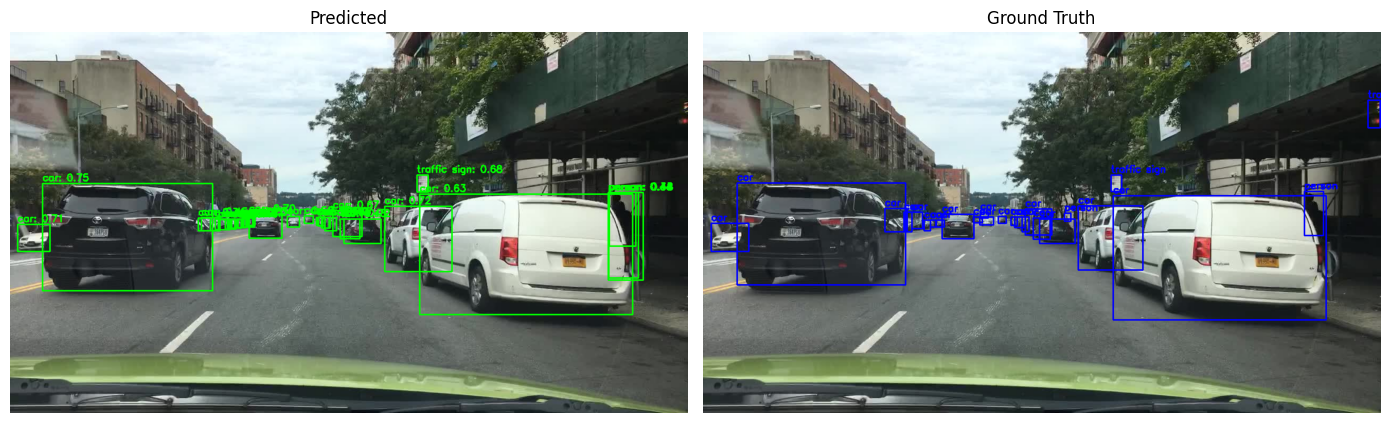


Evaluation for image: b3d6c39a-0a14df0d.jpg
Total GT objects     : 25
Predicted objects    : 32
Matched objects (IoU ≥ 0.5) : 17
Precision            : 0.53
Recall               : 0.68
Correct class ratio  : 1.00


In [6]:
import cv2
import json
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from transformers import RTDetrForObjectDetection, RTDetrImageProcessor

# === Параметры ===
image_path = r"C:\Users\odara\Downloads\data\val\images\b3d6c39a-0a14df0d.jpg"
checkpoint_path = r"C:\Users\odara\Downloads\data\rtdetr_fine_tuning\checkpoint-210000"
bdd_labels_path = r"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_val.json"
iou_threshold = 0.5

# === Классы (id ↔ name) из ground truth ===
categories = [
    {"id": 0, "name": "car"},
    {"id": 1, "name": "traffic sign"},
    {"id": 2, "name": "traffic light"},
    {"id": 3, "name": "person"},
    {"id": 4, "name": "truck"},
    {"id": 5, "name": "bus"},
    {"id": 6, "name": "two_wheeler"},
    {"id": 7, "name": "rider"},
]
id_to_name = {cat["id"]: cat["name"] for cat in categories}

# === Загрузка модели и процессора ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RTDetrForObjectDetection.from_pretrained(checkpoint_path).to(device)
# processor = RTDetrImageProcessor.from_pretrained(checkpoint_path)
processor = RTDetrImageProcessor.from_pretrained(
    "PekingU/rtdetr_r101vd_coco_o365",
    size={"height": 512, "width": 512}
)

# === Загрузка изображения ===
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# === Инференс ===
inputs = processor(images=image_rgb, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

target_sizes = torch.tensor([image_rgb.shape[:2]])  # (height, width)
results = processor.post_process_object_detection(outputs, threshold=0.3, target_sizes=target_sizes)[0]

pred_boxes = results["boxes"].cpu().numpy()
pred_scores = results["scores"].cpu().numpy()
pred_classes = results["labels"].cpu().numpy()

# === Загрузка GT аннотаций ===
with open(bdd_labels_path, 'r') as f:
    bdd_data = json.load(f)

image_name = Path(image_path).name
gt_boxes = []
gt_classes = []

for item in bdd_data:
    if item['name'] == image_name:
        for label in item.get('labels', []):
            box2d = label.get('box2d')
            if box2d:
                x1, y1 = box2d['x1'], box2d['y1']
                x2, y2 = box2d['x2'], box2d['y2']
                gt_boxes.append([x1, y1, x2, y2])
                gt_classes.append(label['category'])
        break

# === Визуализация ===
def draw_boxes(image, boxes, classes, scores=None, title="", is_pred=False):
    image = image.copy()
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cls = str(classes[i])
        color = (0, 255, 0) if is_pred else (255, 0, 0)
        
        # Формируем текст с confidence, если есть scores
        if scores is not None:
            conf = scores[i]
            text = f"{cls}: {conf:.2f}"
        else:
            text = cls

        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
draw_boxes(
    image, 
    pred_boxes, 
    [id_to_name.get(int(i), "unknown") for i in pred_classes], 
    scores=pred_scores, 
    title="Predicted", 
    is_pred=True
)

plt.subplot(1, 2, 2)
draw_boxes(image, gt_boxes, gt_classes, title="Ground Truth", is_pred=False)
plt.tight_layout()
plt.show()

# === IoU-функция ===
def compute_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    inter_area = max(0, xB - xA) * max(0, yB - yA)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area else 0

# === Сравнение предсказаний и GT ===
matched = 0
correct_class = 0
used_gt = set()

for i, pbox in enumerate(pred_boxes):
    pred_label_name = id_to_name.get(int(pred_classes[i]), "unknown")
    for j, gtbox in enumerate(gt_boxes):
        if j in used_gt:
            continue
        iou = compute_iou(pbox, gtbox)
        if iou >= iou_threshold:
            matched += 1
            used_gt.add(j)
            if pred_label_name == gt_classes[j]:
                correct_class += 1
            break

# === Метрики ===
total_gt = len(gt_boxes)
precision = matched / len(pred_boxes) if pred_boxes.any() else 0
recall = matched / total_gt if total_gt else 0
cls_accuracy = correct_class / matched if matched else 0

print(f"\nEvaluation for image: {image_name}")
print(f"Total GT objects     : {total_gt}")
print(f"Predicted objects    : {len(pred_boxes)}")
print(f"Matched objects (IoU ≥ {iou_threshold}) : {matched}")
print(f"Precision            : {precision:.2f}")
print(f"Recall               : {recall:.2f}")
print(f"Correct class ratio  : {cls_accuracy:.2f}")

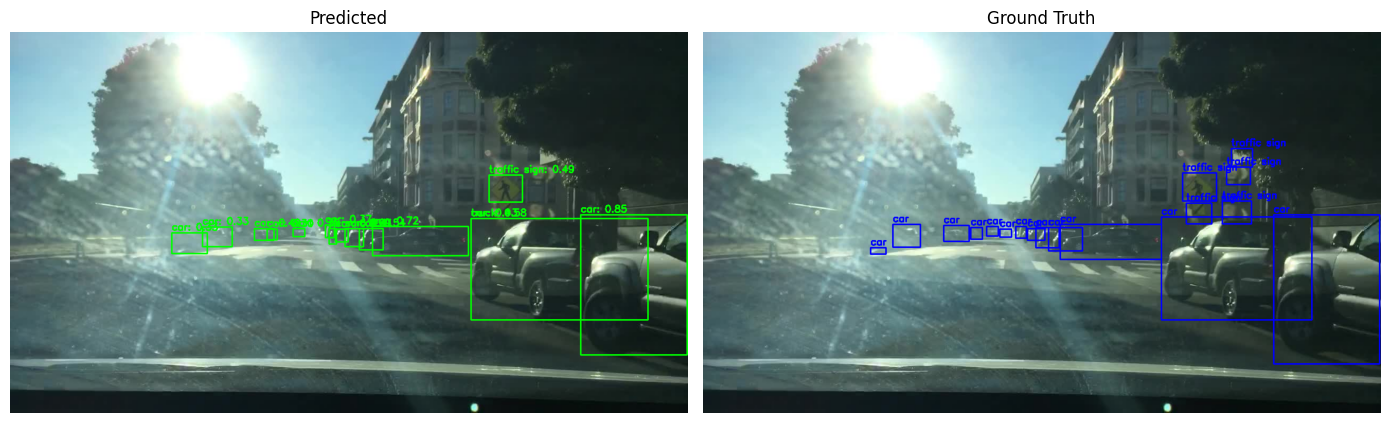


Evaluation for image: b4b07c88-3e6d65a0.jpg
Total GT objects     : 18
Predicted objects    : 16
Matched objects (IoU ≥ 0.5) : 11
Precision            : 0.69
Recall               : 0.61
Correct class ratio  : 0.91


In [8]:
import cv2
import json
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from transformers import RTDetrForObjectDetection, RTDetrImageProcessor

# === Параметры ===
image_path = r"C:\Users\odara\Downloads\data\val\images\b4b07c88-3e6d65a0.jpg"
checkpoint_path = r"C:\Users\odara\Downloads\data\rtdetr_fine_tuning\checkpoint-210000"
bdd_labels_path = r"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_val.json"
iou_threshold = 0.5

# === Классы (id ↔ name) из ground truth ===
categories = [
    {"id": 0, "name": "car"},
    {"id": 1, "name": "traffic sign"},
    {"id": 2, "name": "traffic light"},
    {"id": 3, "name": "person"},
    {"id": 4, "name": "truck"},
    {"id": 5, "name": "bus"},
    {"id": 6, "name": "two_wheeler"},
    {"id": 7, "name": "rider"},
]
id_to_name = {cat["id"]: cat["name"] for cat in categories}

# === Загрузка модели и процессора ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RTDetrForObjectDetection.from_pretrained(checkpoint_path).to(device)
# processor = RTDetrImageProcessor.from_pretrained(checkpoint_path)
processor = RTDetrImageProcessor.from_pretrained(
    "PekingU/rtdetr_r101vd_coco_o365",
    size={"height": 512, "width": 512}
)

# === Загрузка изображения ===
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# === Инференс ===
inputs = processor(images=image_rgb, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

target_sizes = torch.tensor([image_rgb.shape[:2]])  # (height, width)
results = processor.post_process_object_detection(outputs, threshold=0.3, target_sizes=target_sizes)[0]

pred_boxes = results["boxes"].cpu().numpy()
pred_scores = results["scores"].cpu().numpy()
pred_classes = results["labels"].cpu().numpy()

# === Загрузка GT аннотаций ===
with open(bdd_labels_path, 'r') as f:
    bdd_data = json.load(f)

image_name = Path(image_path).name
gt_boxes = []
gt_classes = []

for item in bdd_data:
    if item['name'] == image_name:
        for label in item.get('labels', []):
            box2d = label.get('box2d')
            if box2d:
                x1, y1 = box2d['x1'], box2d['y1']
                x2, y2 = box2d['x2'], box2d['y2']
                gt_boxes.append([x1, y1, x2, y2])
                gt_classes.append(label['category'])
        break

# === Визуализация ===
def draw_boxes(image, boxes, classes, scores=None, title="", is_pred=False):
    image = image.copy()
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cls = str(classes[i])
        color = (0, 255, 0) if is_pred else (255, 0, 0)
        
        # Формируем текст с confidence, если есть scores
        if scores is not None:
            conf = scores[i]
            text = f"{cls}: {conf:.2f}"
        else:
            text = cls

        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
draw_boxes(
    image, 
    pred_boxes, 
    [id_to_name.get(int(i), "unknown") for i in pred_classes], 
    scores=pred_scores, 
    title="Predicted", 
    is_pred=True
)

plt.subplot(1, 2, 2)
draw_boxes(image, gt_boxes, gt_classes, title="Ground Truth", is_pred=False)
plt.tight_layout()
plt.show()

# === IoU-функция ===
def compute_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    inter_area = max(0, xB - xA) * max(0, yB - yA)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area else 0

# === Сравнение предсказаний и GT ===
matched = 0
correct_class = 0
used_gt = set()

for i, pbox in enumerate(pred_boxes):
    pred_label_name = id_to_name.get(int(pred_classes[i]), "unknown")
    for j, gtbox in enumerate(gt_boxes):
        if j in used_gt:
            continue
        iou = compute_iou(pbox, gtbox)
        if iou >= iou_threshold:
            matched += 1
            used_gt.add(j)
            if pred_label_name == gt_classes[j]:
                correct_class += 1
            break

# === Метрики ===
total_gt = len(gt_boxes)
precision = matched / len(pred_boxes) if pred_boxes.any() else 0
recall = matched / total_gt if total_gt else 0
cls_accuracy = correct_class / matched if matched else 0

print(f"\nEvaluation for image: {image_name}")
print(f"Total GT objects     : {total_gt}")
print(f"Predicted objects    : {len(pred_boxes)}")
print(f"Matched objects (IoU ≥ {iou_threshold}) : {matched}")
print(f"Precision            : {precision:.2f}")
print(f"Recall               : {recall:.2f}")
print(f"Correct class ratio  : {cls_accuracy:.2f}")

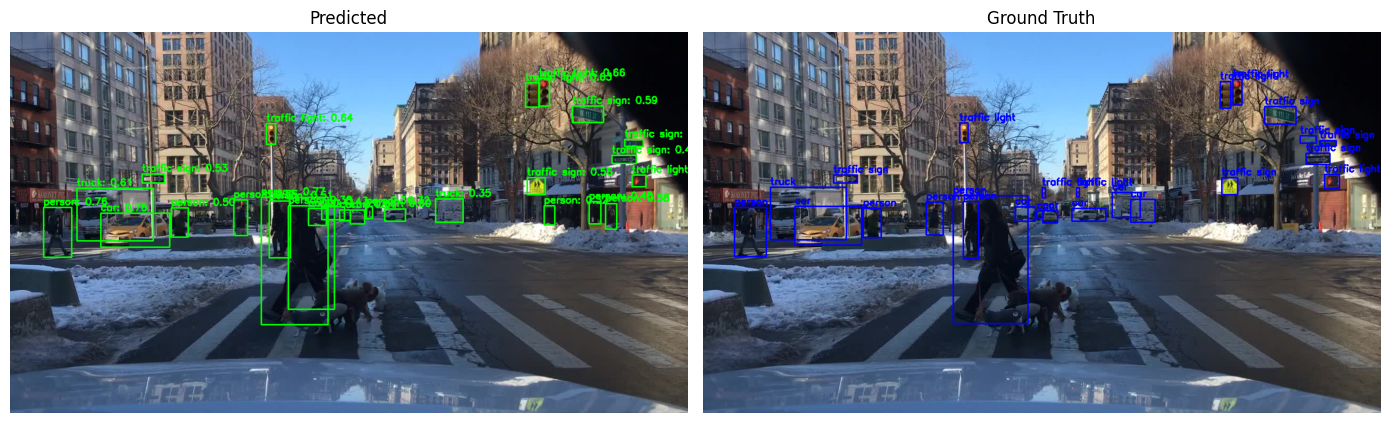


Evaluation for image: b6b047b4-7bdf1e93.jpg
Total GT objects     : 25
Predicted objects    : 28
Matched objects (IoU ≥ 0.5) : 20
Precision            : 0.71
Recall               : 0.80
Correct class ratio  : 0.95


In [10]:
import cv2
import json
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from transformers import RTDetrForObjectDetection, RTDetrImageProcessor

# === Параметры ===
image_path = r"C:\Users\odara\Downloads\data\val\images\b6b047b4-7bdf1e93.jpg"
checkpoint_path = r"C:\Users\odara\Downloads\data\rtdetr_fine_tuning\checkpoint-210000"
bdd_labels_path = r"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_val.json"
iou_threshold = 0.5

# === Классы (id ↔ name) из ground truth ===
categories = [
    {"id": 0, "name": "car"},
    {"id": 1, "name": "traffic sign"},
    {"id": 2, "name": "traffic light"},
    {"id": 3, "name": "person"},
    {"id": 4, "name": "truck"},
    {"id": 5, "name": "bus"},
    {"id": 6, "name": "two_wheeler"},
    {"id": 7, "name": "rider"},
]
id_to_name = {cat["id"]: cat["name"] for cat in categories}

# === Загрузка модели и процессора ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RTDetrForObjectDetection.from_pretrained(checkpoint_path).to(device)
# processor = RTDetrImageProcessor.from_pretrained(checkpoint_path)
processor = RTDetrImageProcessor.from_pretrained(
    "PekingU/rtdetr_r101vd_coco_o365",
    size={"height": 512, "width": 512}
)

# === Загрузка изображения ===
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# === Инференс ===
inputs = processor(images=image_rgb, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

target_sizes = torch.tensor([image_rgb.shape[:2]])  # (height, width)
results = processor.post_process_object_detection(outputs, threshold=0.3, target_sizes=target_sizes)[0]

pred_boxes = results["boxes"].cpu().numpy()
pred_scores = results["scores"].cpu().numpy()
pred_classes = results["labels"].cpu().numpy()

# === Загрузка GT аннотаций ===
with open(bdd_labels_path, 'r') as f:
    bdd_data = json.load(f)

image_name = Path(image_path).name
gt_boxes = []
gt_classes = []

for item in bdd_data:
    if item['name'] == image_name:
        for label in item.get('labels', []):
            box2d = label.get('box2d')
            if box2d:
                x1, y1 = box2d['x1'], box2d['y1']
                x2, y2 = box2d['x2'], box2d['y2']
                gt_boxes.append([x1, y1, x2, y2])
                gt_classes.append(label['category'])
        break

# === Визуализация ===
def draw_boxes(image, boxes, classes, scores=None, title="", is_pred=False):
    image = image.copy()
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cls = str(classes[i])
        color = (0, 255, 0) if is_pred else (255, 0, 0)
        
        # Формируем текст с confidence, если есть scores
        if scores is not None:
            conf = scores[i]
            text = f"{cls}: {conf:.2f}"
        else:
            text = cls

        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
draw_boxes(
    image, 
    pred_boxes, 
    [id_to_name.get(int(i), "unknown") for i in pred_classes], 
    scores=pred_scores, 
    title="Predicted", 
    is_pred=True
)

plt.subplot(1, 2, 2)
draw_boxes(image, gt_boxes, gt_classes, title="Ground Truth", is_pred=False)
plt.tight_layout()
plt.show()

# === IoU-функция ===
def compute_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    inter_area = max(0, xB - xA) * max(0, yB - yA)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area else 0

# === Сравнение предсказаний и GT ===
matched = 0
correct_class = 0
used_gt = set()

for i, pbox in enumerate(pred_boxes):
    pred_label_name = id_to_name.get(int(pred_classes[i]), "unknown")
    for j, gtbox in enumerate(gt_boxes):
        if j in used_gt:
            continue
        iou = compute_iou(pbox, gtbox)
        if iou >= iou_threshold:
            matched += 1
            used_gt.add(j)
            if pred_label_name == gt_classes[j]:
                correct_class += 1
            break

# === Метрики ===
total_gt = len(gt_boxes)
precision = matched / len(pred_boxes) if pred_boxes.any() else 0
recall = matched / total_gt if total_gt else 0
cls_accuracy = correct_class / matched if matched else 0

print(f"\nEvaluation for image: {image_name}")
print(f"Total GT objects     : {total_gt}")
print(f"Predicted objects    : {len(pred_boxes)}")
print(f"Matched objects (IoU ≥ {iou_threshold}) : {matched}")
print(f"Precision            : {precision:.2f}")
print(f"Recall               : {recall:.2f}")
print(f"Correct class ratio  : {cls_accuracy:.2f}")